In [344]:
import pandas as pd
import sqlite3
import math
import matplotlib.pyplot as plt
import os

# uses positioning information from GeoNames (https://www.geonames.org) to find landfall country/state from coordinates
# GeoNames database from https://download.geonames.org/export/dump/
# need US, Mexico, and Canada to differentiate landfalls that are close
geonames_dbs_txt = ['US/US.txt', 'MX/MX.txt', 'CA/CA.txt']
# this will be created in the cell below
geonames_db_sqlite = 'USMXCA.sqlite'

# best track data from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_na_csv = 'ibtracs.NA.list.v04r00.csv'
best_tracks_ep_csv = 'ibtracs.EP.list.v04r00.csv'

# Constants for Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# for calculating probabilities
default_start_year = 1851
default_end_year = 2002

# Function to calculate the Haversine distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c

    return distance


def find_nearest_country_and_state(conn, lat, lon):
    cursor = conn.cursor()
    
    # Query the database to find the nearest place based on coordinates
    cursor.execute("""
        SELECT country, state, latitude, longitude FROM geonames
        WHERE latitude BETWEEN ? AND ?
        AND longitude BETWEEN ? AND ?
        ORDER BY ((latitude - ?) * (latitude - ?) + (longitude - ?) * (longitude - ?))
        LIMIT 1
    """, (lat - 1, lat + 1, lon - 1, lon + 1, lat, lat, lon, lon))

    result = cursor.fetchone()
    cursor.close()

    if result:
        country, state, place_lat, place_lon = result
        if str(state) != '00':
            distance = haversine_distance(lat, lon, place_lat, place_lon)
            return country, state, distance

    return None, None, None

# create a new empty dataframe with same template
def copy_df_structure(df_reference):
    new_df = df_reference.copy(deep=False)
    new_df.astype(df_reference.dtypes.to_dict())
    new_df = new_df[0:0]
    return new_df

# add landfall state for all US tropical storms and subtropical storms
def get_us_landfalls(df_reference):
    df_new_landfalls = copy_df_structure(df_reference)
    df_new_landfalls.reset_index()
    US_state_abbrevs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    # Connect to the SQLite database containing Geonames data
    conn = sqlite3.connect(geonames_db_sqlite)
    us_state_landfalls = []
    for i in range(len(df_reference)):
        entry = df_reference.iloc[i]
        latitude = float(entry['USA_LAT'])
        longitude = float(entry['USA_LON'])

        country, state, distance_km = find_nearest_country_and_state(conn, latitude, longitude)
        # it may return state='00' if Mexico is not in sqlite database so double check state is in abbrevs
        if country == 'US' and state in US_state_abbrevs:
            df_new_landfalls.loc[len(df_new_landfalls)] = entry
            df_new_landfalls.reset_index()
            us_state_landfalls.append(state)

    # Don't forget to close the database connection when you're done
    conn.close()

    df_new_landfalls.reset_index()
    df_new_landfalls_with_state = df_new_landfalls.copy(deep=True)
    df_new_landfalls_with_state = df_new_landfalls_with_state.assign(LANDFALL_STATE=us_state_landfalls)
    return df_new_landfalls_with_state

# get the df with us landfall states (or the unique storms when no state supplied), selected by:
#     start/end year,
#     a list of US states where landfall occured (must be a list)
#     from a range within each year (start/end month and day; both must be supplied)
def get_landfalling_conditional(df_reference, states=None,
                                start_year=default_start_year, end_year=default_end_year,
                                start_month_num=None, start_day_num_of_month=None,
                                end_month_num=None, end_day_num_of_month=None):
    # might have multiple landfalls with the same storm, so only count each storm once
    df_new = df_reference.copy(deep=True)
    year_range = list(range(start_year, end_year + 1, 1))
    if states is not None:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range)) & (df_new['LANDFALL_STATE'].isin(states))]
    else:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range))]
    df_new.reset_index()
    # get the mataching year and state first, then drop storm duplicates
    df_new = df_new.drop_duplicates(subset=['USA_ATCF_ID'])
    df_new.reset_index()
    if start_month_num and end_month_num and start_day_num_of_month and end_day_num_of_month:
        # Only include those within the month-day range (inclusive)
        df_new['month'] = df_new['ISO_TIME'].dt.month
        df_new['day'] = df_new['ISO_TIME'].dt.day
        df_new['month_day_sum'] = (df_new['month'] * 100) + df_new['day']
        start_month_day_sum = (start_month_num * 100) + start_day_num_of_month
        end_month_day_sum = (end_month_num * 100) + end_day_num_of_month
        df_new = df_new.loc[
            (df_new['month_day_sum'] >= start_month_day_sum) &
            (df_new['month_day_sum'] <= end_month_day_sum)
        ]
        df_new.reset_index()

    return df_new

# calculate expected probability for exactly expected_num_events this year, given:
#   that a total of num_events have happened over num_years
def poisson_pmf(num_years, num_events, expected_num_events):
    p = num_events / num_years
    xfact = math.factorial(expected_num_events)
    ep = math.pow(p, expected_num_events) / (math.exp(p) * xfact)
    return ep

In [345]:

















############################################### 
#### VERY SLOW ... SKIP TO "START HERE"
###############################################























In [346]:
# create the geonames db (only do once!)

## ONLY RUN THIS CELL ONCE
if not os.path.isfile(geonames_db_sqlite):
    # Create a new SQLite database or connect to an existing one
    conn = sqlite3.connect(geonames_db_sqlite)
    cursor = conn.cursor()

    # Create a table to store the Geonames data
    cursor.execute('''
        CREATE TABLE geonames (
            geonameid INTEGER PRIMARY KEY,
            name TEXT,
            latitude REAL,
            longitude REAL,
            country TEXT,
            state TEXT
        )
    ''')

    for geonames_db_txt in geonames_dbs_txt:
        # Read and import data from the "US.txt" file into the database
        with open(geonames_db_txt, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 10:
                    geonameid, name, latitude, longitude, country, state = (
                        int(parts[0]), parts[1], float(parts[4]), float(parts[5]), parts[8], parts[10]
                    )
                    cursor.execute('''
                        INSERT INTO geonames (geonameid, name, latitude, longitude, country, state)
                        VALUES (?, ?, ?, ?, ?, ?)
                    ''', (geonameid, name, latitude, longitude, country, state))

    # Commit changes and close the database connection
    conn.commit()
    conn.close()


In [347]:
#############################################################################
# READ THE TRACKS AND DO THE LANDFALL CALCULATIONS IN BELOW CELLS (VERY SLOW)
# ONLY NEED TO DO ONCE SINCE PARQUETS ARE PRECOMPUTED
#############################################################################

In [348]:
# Read the CSV file into a DataFrame without automatically assigning column names
df_na = pd.read_csv(best_tracks_na_csv, header=0, skiprows=[1], low_memory=False)
df_ep = pd.read_csv(best_tracks_ep_csv, header=0, skiprows=[1], low_memory=False)
# store all related basin dataframes in one list, with the main one (read from file) separately
dfs_by_basin = {'NA': {'main': df_na}, 'EP': {'main': df_ep}}

In [349]:
# get landfalls for ts/ss/hu (>=34kt) and compute landfall states for both basins (north atlantic and east pacific)
#   only include rows with unique landfall state/storm combinations:
#      don't have rows for storm that have landfalling twice in same storm
#   so, there may be multiple landfalls per storm if a storm landfalls in multiple states,
#      but each state will have a specific storm landfalling only once in that state
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_landfalls = df.loc[(df['USA_RECORD'] == 'L')]
    df_ts_ss_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['HU', 'HR']))]
    df_landfalls.reset_index()
    df_ts_ss_landfalls.reset_index()
    df_hu_landfalls.reset_index()
    
    # this will take a while as geonames is slow
    df_us_ts_ss_landfalls_with_state = get_us_landfalls(df_ts_ss_landfalls)
    df_us_hu_landfalls_with_state = get_us_landfalls(df_hu_landfalls)
    
    # for the above landfalls there are duplicates for a single state with different timestamps
    df_us_ts_ss_landfalls_with_state_no_dupe_times = df_us_ts_ss_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_hu_landfalls_with_state_no_dupe_times = df_us_hu_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = pd.concat([df_us_ts_ss_landfalls_with_state_no_dupe_times, df_us_hu_landfalls_with_state_no_dupe_times])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])

    dict_dfs['us_landfalls_ts_ss'] = df_us_ts_ss_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_hu'] = df_us_hu_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_ts_ss_hu'] = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times
    dfs_by_basin[basin_name] = dict_dfs

In [350]:
# get ts/ss/hu storms (>=34kt) for both basins (north atlantic and east pacific)
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_ts_ss = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['HU', 'HR']))]
    df_ts_ss.reset_index()
    df_hu.reset_index()
    df_ts_ss_hu = pd.concat([df_ts_ss,df_hu])
    df_ts_ss_hu.reset_index()    
    
    dict_dfs['ts_ss'] = df_ts_ss
    dict_dfs['hu'] = df_hu
    dict_dfs['ts_ss_hu'] = df_ts_ss_hu
    dfs_by_basin[basin_name] = dict_dfs

In [351]:
# write the parquets
for basin_name, dict_dfs in dfs_by_basin.items():
    for df_name, dict_df in dict_dfs.items():
        parquet_name = basin_name + '_basin_' + df_name + ".parquet"
        dict_df.to_parquet(parquet_name)

In [352]:
print(dfs_by_basin['NA'].keys())
print(dfs_by_basin['EP'].keys())

dict_keys(['main', 'us_landfalls_ts_ss', 'us_landfalls_hu', 'us_landfalls_ts_ss_hu', 'ts_ss', 'hu', 'ts_ss_hu'])
dict_keys(['main', 'us_landfalls_ts_ss', 'us_landfalls_hu', 'us_landfalls_ts_ss_hu', 'ts_ss', 'hu', 'ts_ss_hu'])


In [353]:
# COMBINE NA AND EP for US landfalling storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep_us_landfalls = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_us_landfalls_ts_ss = dict_dfs['us_landfalls_ts_ss'].copy(deep=True)
    df_us_landfalls_hu = dict_dfs['us_landfalls_hu'].copy(deep=True)
    df_us_landfalls_ts_ss_hu = dict_dfs['us_landfalls_ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_us_landfalls_ts_ss)
    dfs_tmp['hu'].append(df_us_landfalls_hu)
    dfs_tmp['ts_ss_hu'].append(df_us_landfalls_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep_us_landfalls[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep_us_landfalls[dict_name].reset_index()

In [354]:
# write the parquets
for df_name, dict_df in dfs_na_ep_us_landfalls.items():
    parquet_name = 'na_ep_us_landfalls_' + df_name + ".parquet"
    dict_df.to_parquet(parquet_name)

In [355]:
# COMBINE NA AND EP for all storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_ts_ss = dict_dfs['ts_ss'].copy(deep=True)
    df_hu = dict_dfs['hu'].copy(deep=True)
    df_ts_ss_hu = dict_dfs['ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_ts_ss)
    dfs_tmp['hu'].append(df_hu)
    dfs_tmp['ts_ss_hu'].append(df_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep[dict_name].reset_index()

In [356]:
# write the parquets
for df_name, dict_df in dfs_na_ep.items():
    parquet_name = 'na_ep_' + df_name + ".parquet"
    #print(parquet_name)
    dict_df.to_parquet(parquet_name)

In [ ]:























#######################
##### START HERE ######
#######################

# FIRST, RUN THE FIRST CELL















In [287]:
# LOAD THE PARQUETS BY BASIN 

parquets_by_basin_for_us_landfalls = [
'EP_basin_main.parquet',
'EP_basin_us_landfalls_ts_ss.parquet',
'EP_basin_us_landfalls_hu.parquet',
'EP_basin_us_landfalls_ts_ss_hu.parquet',
'EP_basin_ts_ss.parquet',
'EP_basin_hu.parquet',
'EP_basin_ts_ss_hu.parquet',
'NA_basin_main.parquet',
'NA_basin_us_landfalls_ts_ss.parquet',
'NA_basin_us_landfalls_hu.parquet',
'NA_basin_us_landfalls_ts_ss_hu.parquet',
'NA_basin_ts_ss.parquet',
'NA_basin_hu.parquet',
'NA_basin_ts_ss_hu.parquet',
]

dfs_by_basin = {}
for parquet_file_name in parquets_by_basin_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    basin_name, df_name = parquet_name.split('_basin_')
    if basin_name not in dfs_by_basin:
        dfs_by_basin[basin_name] = {}
    dict_dfs = dfs_by_basin[basin_name]
    dict_dfs[df_name] = pd.read_parquet(parquet_file_name)
    dfs_by_basin[basin_name] = dict_dfs

In [315]:
# LOAD THE PARQUETS BY STORM TYPES FOR US LANDFALLS

parquets_by_storm_types_for_us_landfalls = [
'na_ep_us_landfalls_hu.parquet',
'na_ep_us_landfalls_ts_ss.parquet',
'na_ep_us_landfalls_ts_ss_hu.parquet'
]

dfs_na_ep_us_landfalls = {}
for parquet_file_name in parquets_by_storm_types_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_us_landfalls_')
    dfs_na_ep_us_landfalls[df_name] = pd.read_parquet(parquet_file_name)

In [ ]:
# LOAD THE PARQUETS BY STORM TYPES FOR ALL STORMS

parquets_by_storm_types = [
'na_ep_hu.parquet',
'na_ep_ts_ss.parquet',
'na_ep_ts_ss_hu.parquet'
]

dfs_na_ep = {}
for parquet_file_name in parquets_by_storm_types:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_')
    dfs_na_ep[df_name] = pd.read_parquet(parquet_file_name)

# US Named Storm landfalls (>=34 kt) in records from North Atlantic and East Pacific basins: 516
               SID SEASON NUMBER BASIN SUBBASIN    NAME            ISO_TIME  \
233  1994313N12278   1994    108   NaN      NaN  GORDON 1994-11-15 13:00:00   
244  1998295N12284   1998     89   NaN       GM   MITCH 1998-11-05 11:00:00   
303  2020306N15288   2020    102   NaN      NaN     ETA 2020-11-09 04:00:00   
315  2022311N21293   2022     46   NaN       GM  NICOLE 2022-11-10 19:00:00   
294  1999286N16278   1999     89   NaN      NaN   IRENE 1999-10-15 13:00:00   
313  2005289N18282   2005     97   NaN       GM   WILMA 2005-10-24 10:30:00   
343  2020299N18277   2020    100   NaN       GM    ZETA 2020-10-28 21:00:00   

    NATURE   LAT   LON  ... USA_SEARAD_NE USA_SEARAD_SE USA_SEARAD_SW  \
233     TS  24.6 -81.7  ...                                             
244     TS  26.2 -81.9  ...                                             
303     TS  24.9 -80.7  ...            60          

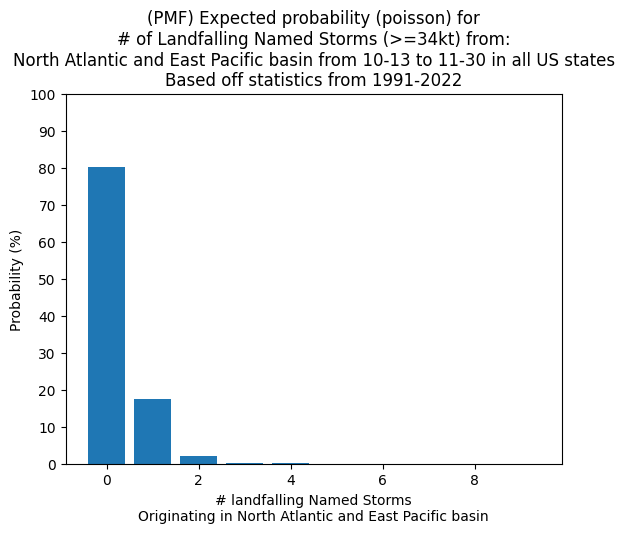

In [357]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS FOR NAMED STORMS (>= 34kt)
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 13
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

df_ref_with_state = dfs_na_ep_us_landfalls['ts_ss_hu'].copy(deep=True)
    
# with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
df_unique_storms.reset_index()
print(f"# US Named Storm landfalls (>=34 kt) in records from {full_basin_name} basins:", len(df_unique_storms))

landfalling_in_period = get_landfalling_conditional(
    df_ref_with_state,
    states=states,
    start_year=start_year, end_year=end_year,
    start_month_num=start_month, start_day_num_of_month=start_day,
    end_month_num=end_month, end_day_num_of_month=end_day
)
print(landfalling_in_period)
num_years = (end_year - start_year + 1)
num_in_period = len(landfalling_in_period)
print(f"# US Named Storm landfalls (>=34 kt) from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

event_counts = list(range(0,10))
ep_pct_per_event_count = []
for n in event_counts:
    ep_pct_per_event_count.append(100 * poisson_pmf(num_years, num_in_period, n))

print(ep_pct_per_event_count)
# Create a bar chart
plt.bar(event_counts, ep_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms\nOriginating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")

# Show the chart
plt.show()

# US Tropical/Subtropical Storm landfalls in records from North Atlantic basin: 273
# US Tropical/Subtropical Storm landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 4
[88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]


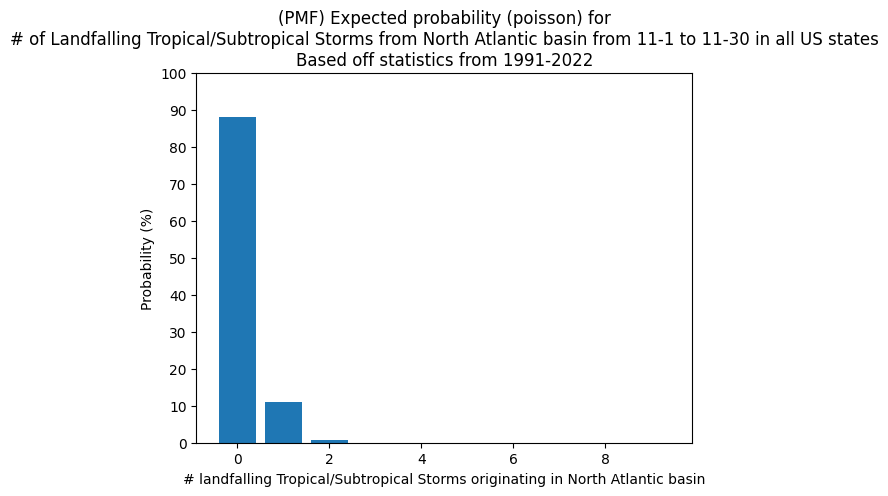

# US Hurricane landfalls in records from North Atlantic basin: 272
# US Hurricane landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 1
[96.9233234476344, 3.028853857738575, 0.047325841527165236, 0.0004929775159079712, 3.851386843031025e-06, 2.4071167768943906e-08, 1.2537066546324952e-10, 5.596904708180781e-13, 2.1862909016331177e-15, 7.59128785289277e-18]


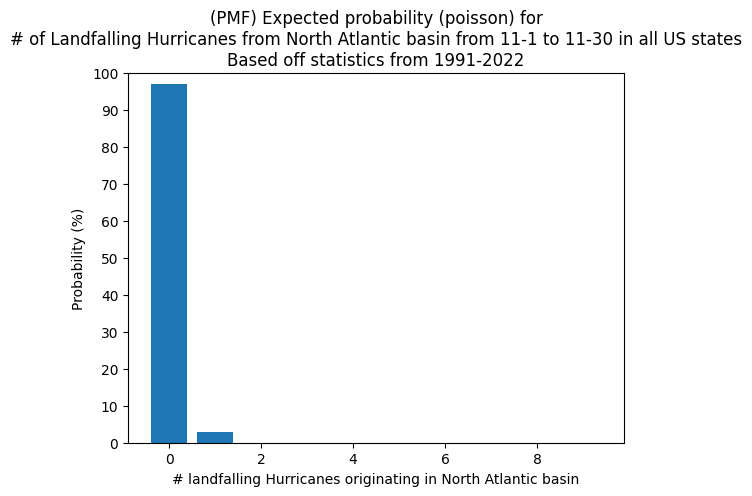

# US Tropical/Subtropical Storm landfalls in records from East Pacific basin: 2
# US Tropical/Subtropical Storm landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


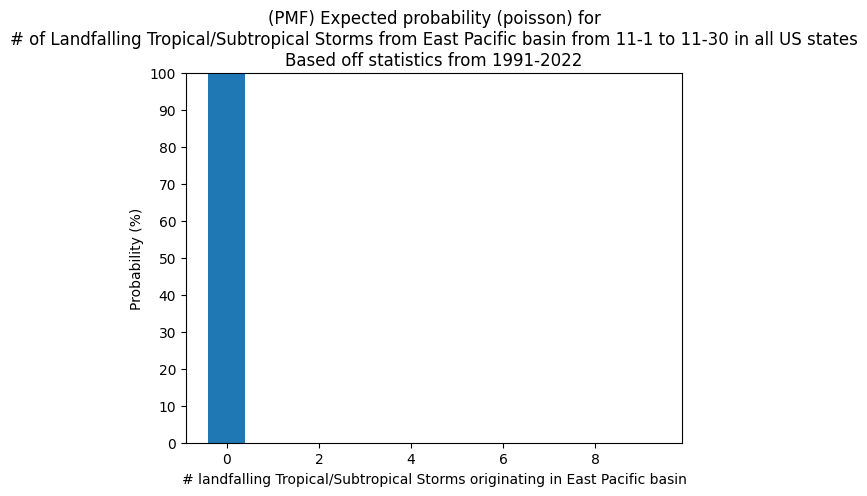

# US Hurricane landfalls in records from East Pacific basin: 4
# US Hurricane landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


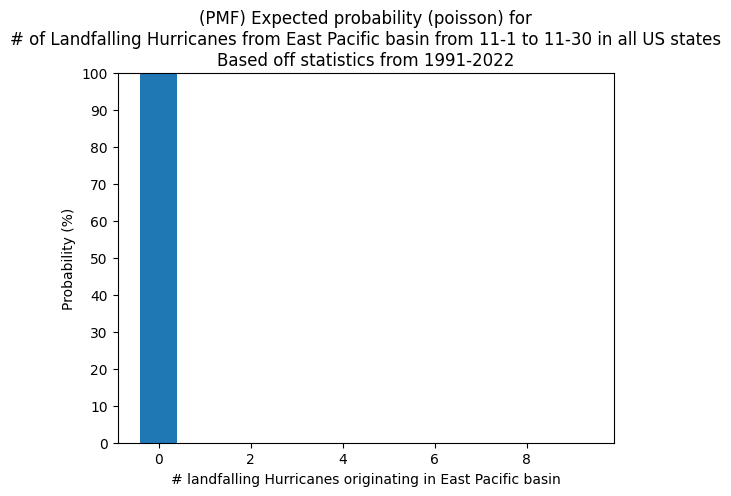

In [358]:
##### BY BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 1
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NJ', 'NY']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]    
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basin:", len(df_unique_storms))
        
        landfalling_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )

        num_years = (end_year - start_year + 1)
        num_in_period = len(landfalling_in_period)
        print(f"# US {storm_type_long} landfalls from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

        event_counts = list(range(0,10))
        ep_pct_per_event_count = []
        for n in event_counts:
            ep_pct_per_event_count.append(100 * poisson_pmf(num_years, num_in_period, n))

        print(ep_pct_per_event_count)
        # Create a bar chart
        plt.bar(event_counts, ep_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        # Show the chart
        plt.show()

In [359]:
print(dfs_by_basin['NA'].keys())


dict_keys(['main', 'us_landfalls_ts_ss', 'us_landfalls_hu', 'us_landfalls_ts_ss_hu', 'ts_ss', 'hu', 'ts_ss_hu'])


# US Tropical/Subtropical Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 274
# US Tropical/Subtropical Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 4
[88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]


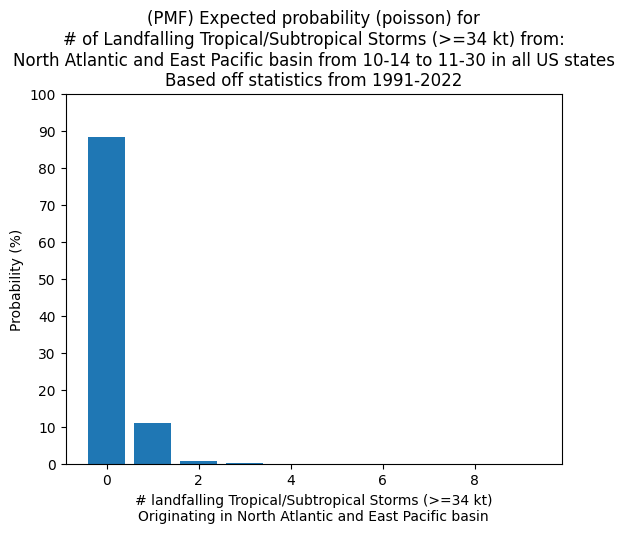

# US Hurricanes landfalls in records from North Atlantic and East Pacific basins: 273
# US Hurricanes landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 4
[88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]


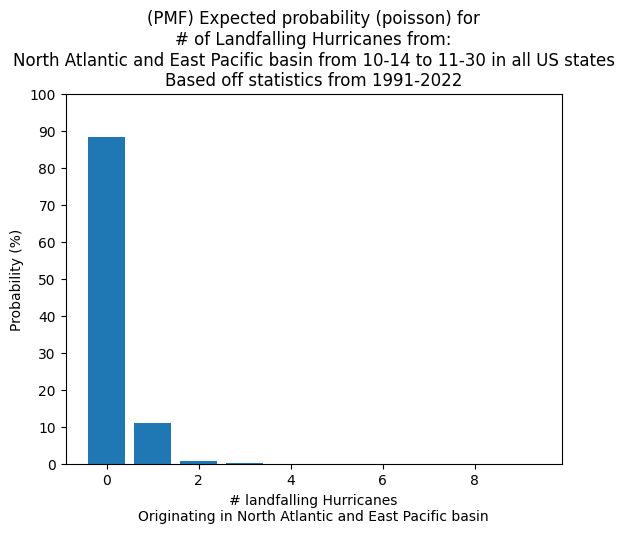

# US Named Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 516
# US Named Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 7
[80.35225736890607, 17.577056299448202, 1.9224905327521473, 0.14018160134651073, 0.007666181323637305, 0.00033539543290913215, 1.2227958491478776e-05, 3.8212370285871175e-07, 1.04486950000429e-08, 2.539613368065982e-10]


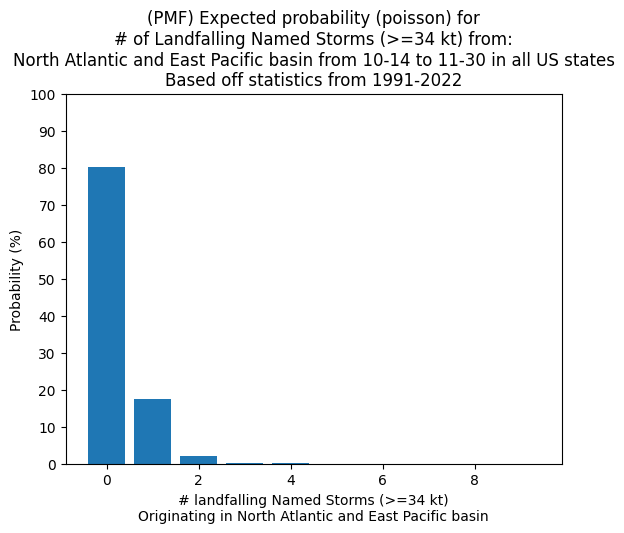

In [360]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 14
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

storm_types = {'TS/SS': 'Tropical/Subtropical Storms (>=34 kt)', 'HU': "Hurricanes", 'TS/SS/HU': 'Named Storms (>=34 kt)'}
storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'TS/SS/HU': 'ts_ss_hu'}
for storm_type_short, storm_type_long in storm_types.items():
    k = storm_type_short_to_dict_key_mapping[storm_type_short]
    df_ref_with_state = dfs_na_ep_us_landfalls[k].copy(deep=True)
    # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
    df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
    df_unique_storms.reset_index()
    print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basins:", len(df_unique_storms))

    landfalling_in_period = get_landfalling_conditional(
        df_ref_with_state,
        states=states,
        start_year=start_year, end_year=end_year,
        start_month_num=start_month, start_day_num_of_month=start_day,
        end_month_num=end_month, end_day_num_of_month=end_day
    )
    num_years = (end_year - start_year + 1)
    num_in_period = len(landfalling_in_period)
    print(f"# US {storm_type_long} landfalls from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

    event_counts = list(range(0,10))
    ep_pct_per_event_count = []
    for n in event_counts:
        ep_pct_per_event_count.append(100 * poisson_pmf(num_years, num_in_period, n))

    print(ep_pct_per_event_count)
    # Create a bar chart
    plt.bar(event_counts, ep_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# landfalling {storm_type_long}\nOriginating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")

    # Show the chart
    plt.show()

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1689
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2022 from 10-10 to 11-30: 77
PMF % (starting from 0): [9.015273423081638, 21.693001674290194, 26.099392639380387, 20.933887846169686, 12.593041907461453, 6.060401417965823, 2.430473485330044, 0.8354752605822027, 0.2512952932219906, 0.06718658881282388, 0.016166772933085747, 0.0035364815791125073, 0.0007091382333116225, 0.00013125875953123783, 2.25600992944315e-05, 3.61901592848172e-06, 5.442660673693212e-07, 7.703766027102524e-08, 1.0298437223730804e-08, 1.3042428720843287e-09, 1.569167205476458e-10, 1.7980040896084414e-11, 1.9665669730092328e-12, 2.057413816871072e-13, 2.0627716653525077e-14, 1.9854177279017888e-15, 1.8374659260629533e-16, 1.63755643873666e-17, 1.407275064539317e-18, 1.1676743531199075e-19]
Cumulative % (starting from 0): [100.0, 90.98472657691836, 69.29172490262818, 43.19233226324779, 22.25844441707811, 9.665402509616653, 3.605

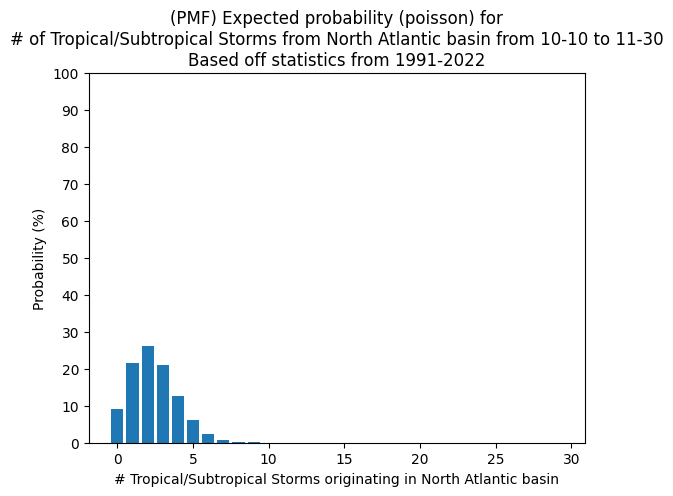

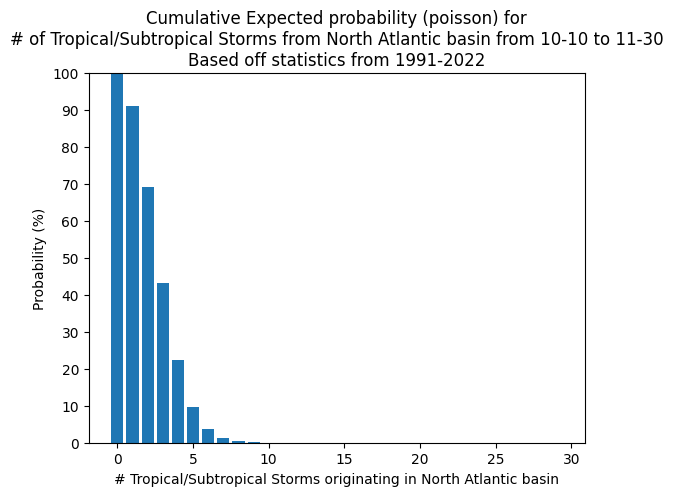

# US Hurricane in records from North Atlantic basin: 963
# US Hurricane from North Atlantic basin, 1991 to 2022 from 10-10 to 11-30: 46
PMF % (starting from 0): [23.752081909545815, 34.14361774497211, 24.540725254198705, 11.75909751763688, 4.225925670400754, 1.2149536302402164, 0.29108264057838523, 0.059775899404489824, 0.010740981924244265, 0.0017155735017890144, 0.00024661369088217083, 3.2227925513010965e-05, 3.860636910412771e-06, 4.2689735067064306e-07, 4.383321011350352e-08, 4.200682635877421e-09, 3.774050805671121e-10, 3.1912929606777854e-11, 2.548602017207954e-12, 1.9282186314402283e-13, 1.3859071413476638e-14, 9.486864360415558e-16, 6.198803417316983e-17, 3.8742521358231145e-18, 2.32051560218572e-19, 1.334296471256789e-20, 7.3771199131985905e-22, 3.9276332871196206e-23, 2.0164188750837335e-24, 9.995179768734027e-26]
Cumulative % (starting from 0): [100.0, 76.24791809045419, 42.10430034548208, 17.563575091283376, 5.804477573646497, 1.578551903245742, 0.36359827300552583, 0.07251

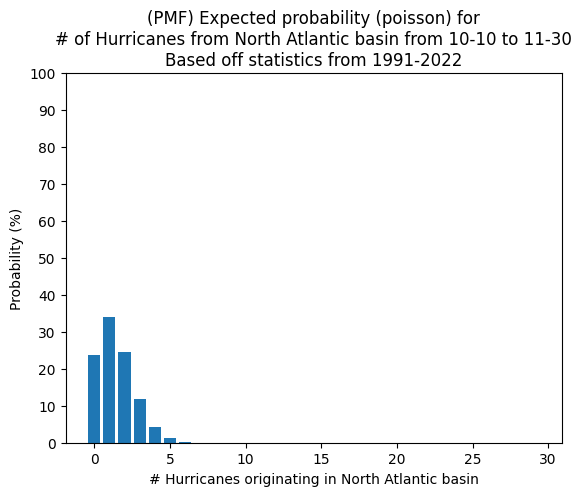

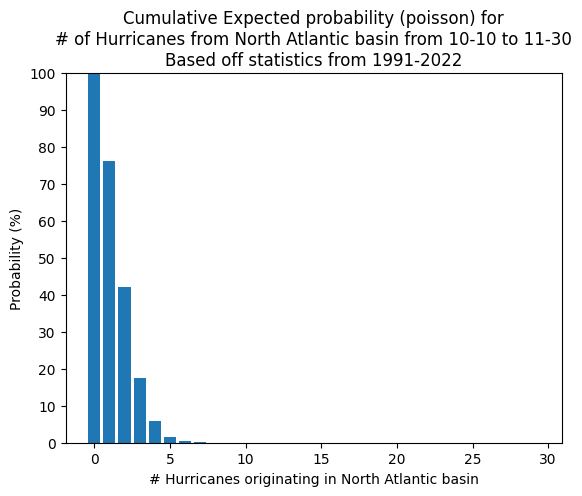

# US Named Storm in records from North Atlantic basin: 1741
# US Named Storm from North Atlantic basin, 1991 to 2022 from 10-10 to 11-30: 77
PMF % (starting from 0): [9.015273423081638, 21.693001674290194, 26.099392639380387, 20.933887846169686, 12.593041907461453, 6.060401417965823, 2.430473485330044, 0.8354752605822027, 0.2512952932219906, 0.06718658881282388, 0.016166772933085747, 0.0035364815791125073, 0.0007091382333116225, 0.00013125875953123783, 2.25600992944315e-05, 3.61901592848172e-06, 5.442660673693212e-07, 7.703766027102524e-08, 1.0298437223730804e-08, 1.3042428720843287e-09, 1.569167205476458e-10, 1.7980040896084414e-11, 1.9665669730092328e-12, 2.057413816871072e-13, 2.0627716653525077e-14, 1.9854177279017888e-15, 1.8374659260629533e-16, 1.63755643873666e-17, 1.407275064539317e-18, 1.1676743531199075e-19]
Cumulative % (starting from 0): [100.0, 90.98472657691836, 69.29172490262818, 43.19233226324779, 22.25844441707811, 9.665402509616653, 3.6050010916508297, 1.1745276063207

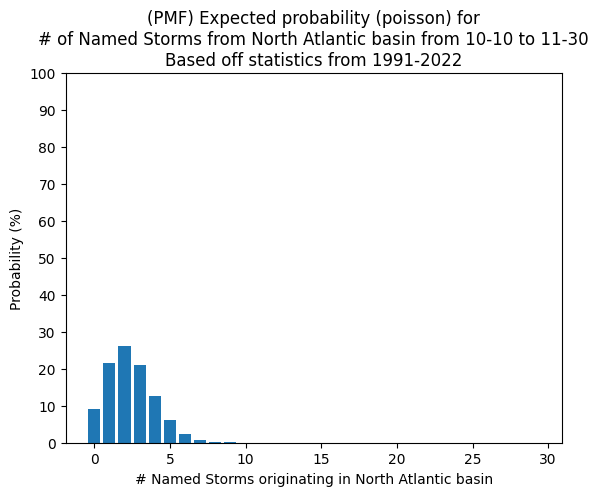

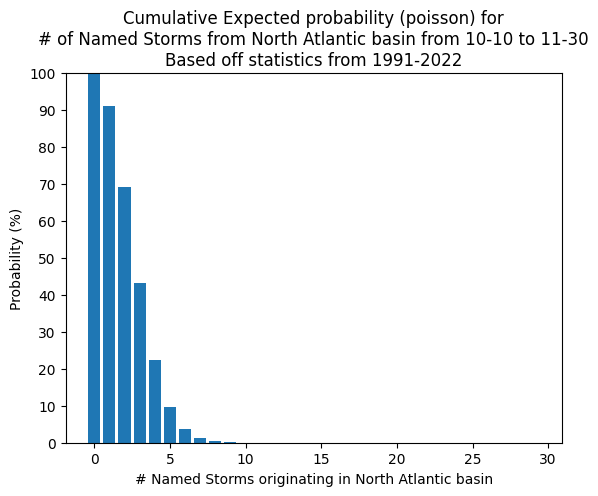

# US Tropical/Subtropical Storm in records from East Pacific basin: 1175
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2022 from 10-10 to 11-30: 79
PMF % (starting from 0): [8.469065618478048, 20.908005745617682, 25.808319592246832, 21.238096331119785, 13.107887579362993, 6.472019492310478, 2.6629663536069152, 0.9391711693524389, 0.2898223530423542, 0.07949988156370132, 0.01962653326103876, 0.0044048185443808585, 0.0009061996484533538, 0.00017209079862455515, 3.034636850745504e-05, 4.994506483518642e-06, 7.706367425741655e-07, 1.1191232107235125e-07, 1.5349085702631506e-08, 1.994371333072186e-09, 2.461802114260979e-10, 2.8940828426579962e-11, 3.2476213717326954e-12, 3.485897939767431e-13, 3.5857543911670195e-14, 3.540932461277431e-15, 3.362183466837945e-16, 3.074218679168955e-17, 2.7105276300708416e-18, 2.3074534781853073e-19]
Cumulative % (starting from 0): [100.0, 91.53093438152194, 70.62292863590426, 44.81460904365743, 23.576512712537642, 10.468625133174648, 3.996

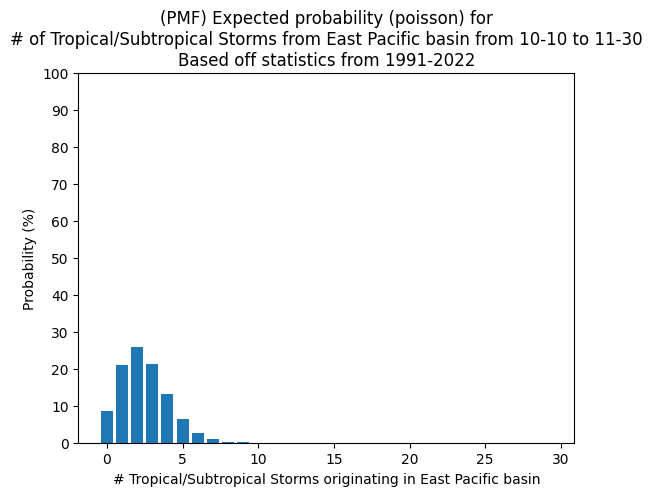

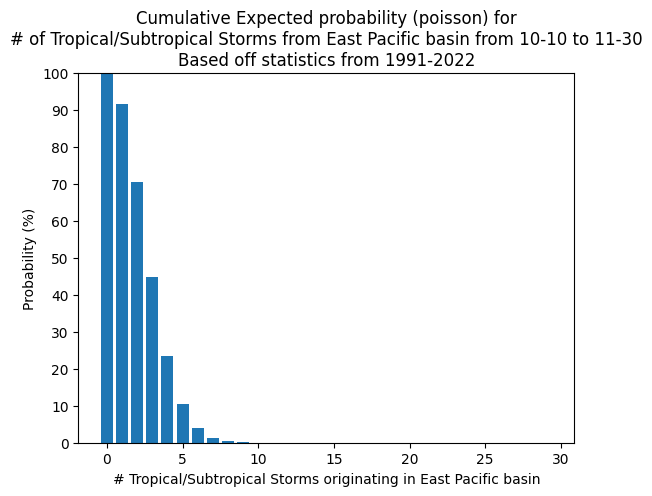

# US Hurricane in records from East Pacific basin: 598
# US Hurricane from East Pacific basin, 1991 to 2022 from 10-10 to 11-30: 30
PMF % (starting from 0): [39.1605626676799, 36.713027500949906, 17.209231641070268, 5.377884887834459, 1.2604417705862012, 0.23633283198491278, 0.036927004997642614, 0.004945581026469993, 0.0005795602765394523, 6.037086213952628e-05, 5.659768325580589e-06, 4.823666186574365e-07, 3.768489208261223e-08, 2.7176604867268436e-09, 1.8198619330760112e-10, 1.137413708172507e-11, 6.664533446323283e-13, 3.675294179957693e-14, 1.9142157187279655e-15, 9.445143348986671e-17, 4.4274109448375015e-18, 1.9765227432310277e-19, 8.422682144450401e-21, 3.433158482792283e-22, 1.341077532340736e-23, 5.029040746277758e-25, 1.8133560383213072e-26, 6.296375133060096e-28, 2.1081613168727996e-29, 6.815176670924999e-31]
Cumulative % (starting from 0): [100.0, 60.839437332320095, 24.126409831370186, 6.917178190299915, 1.5392933024654554, 0.278851531879254, 0.04251869989434116, 0.005591

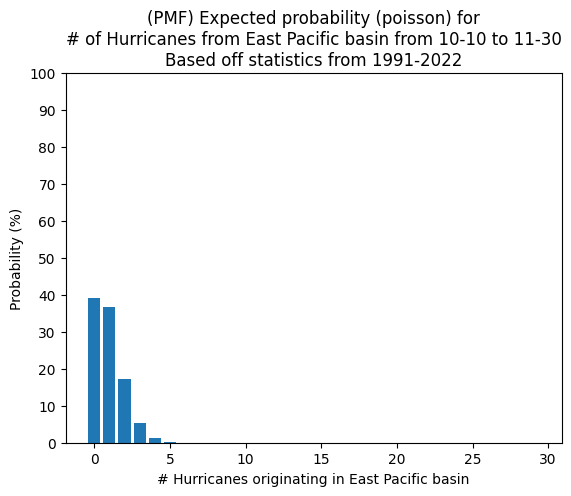

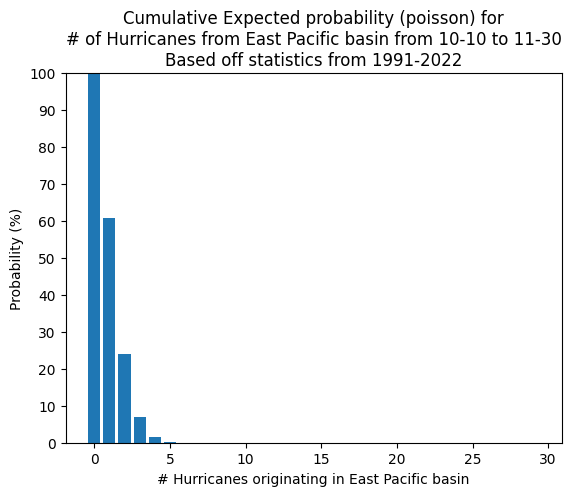

# US Named Storm in records from East Pacific basin: 1216
# US Named Storm from East Pacific basin, 1991 to 2022 from 10-10 to 11-30: 79
PMF % (starting from 0): [8.469065618478048, 20.908005745617682, 25.808319592246832, 21.238096331119785, 13.107887579362993, 6.472019492310478, 2.6629663536069152, 0.9391711693524389, 0.2898223530423542, 0.07949988156370132, 0.01962653326103876, 0.0044048185443808585, 0.0009061996484533538, 0.00017209079862455515, 3.034636850745504e-05, 4.994506483518642e-06, 7.706367425741655e-07, 1.1191232107235125e-07, 1.5349085702631506e-08, 1.994371333072186e-09, 2.461802114260979e-10, 2.8940828426579962e-11, 3.2476213717326954e-12, 3.485897939767431e-13, 3.5857543911670195e-14, 3.540932461277431e-15, 3.362183466837945e-16, 3.074218679168955e-17, 2.7105276300708416e-18, 2.3074534781853073e-19]
Cumulative % (starting from 0): [100.0, 91.53093438152194, 70.62292863590426, 44.81460904365743, 23.576512712537642, 10.468625133174648, 3.9966056408641712, 1.3336392872572

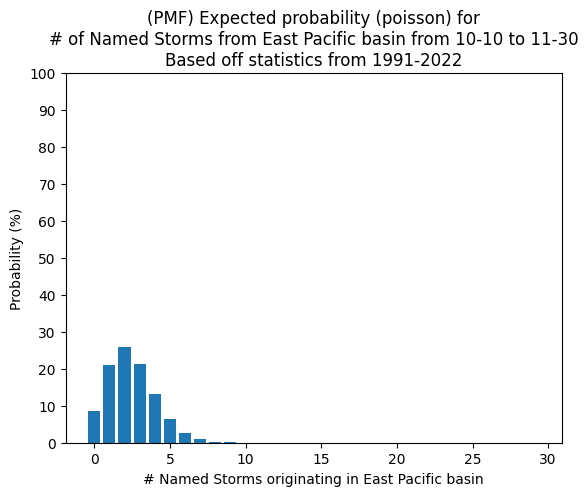

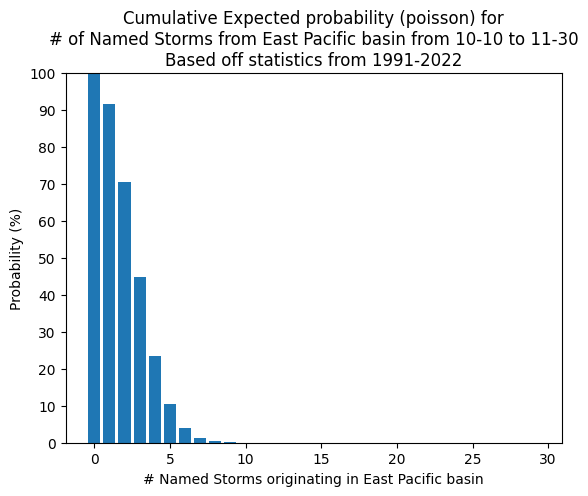

In [363]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 10
end_month = 11
end_day = 30
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        ep_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            ep_pct_per_event_count.append(pct)
        cum_pct_per_event_count = []
        remaining_pct = pct_total
        # get cumulative probability from pdf
        for pct in ep_pct_per_event_count:
            cum_pct_per_event_count.append(100 * remaining_pct / pct_total)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", ep_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, ep_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()